In [1]:
import shutil, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import matplotlib.pyplot as plt
import numpy as np
import detectron2
from detectron2.data import DatasetCatalog,MetadataCatalog
from plain_train_net import grab_dataset

reprocess_results=False
dataset_name = "test"
dpi=120

In [2]:
#predict
from detectron2.config import get_cfg
cfg = get_cfg()
cfg.merge_from_file('configs/working.yaml')
#really low iou for nms in order to separate out lesions
# cfg.merge_from_list(["MODEL.WEIGHTS", "output_valid_"+ dataset_name + "/model_final.pth",
#                      "OUTPUT_DIR", "output_valid_"+ dataset_name + "/results"])
cfg.merge_from_list(["OUTPUT_DIR", "output_"+ dataset_name])
# print(cfg.dump())  # print formatted configs
print(cfg.MODEL.ROI_HEADS.dump())
print(cfg.MODEL.WEIGHTS)
print(cfg.OUTPUT_DIR)


BATCH_SIZE_PER_IMAGE: 512
IN_FEATURES:
- p2
- p3
- p4
- p5
IOU_LABELS:
- 0
- 1
IOU_THRESHOLDS:
- 0.5
NAME: StandardROIHeads
NMS_THRESH_TEST: 0.01
NUM_CLASSES: 1
POSITIVE_FRACTION: 0.25
PROPOSAL_APPEND_GT: true
SCORE_THRESH_TEST: 0.001

detectron2://ImageNetPretrained/FAIR/X-101-32x8d.pkl
output_test


In [3]:
for name in [dataset_name]:
    try:
        DatasetCatalog.register(name, grab_dataset(name))
    except:
        print('Already registered.')
        #do nothing
    MetadataCatalog.get(name).thing_classes = ["rpd"]

In [4]:
if reprocess_results:
    #build model
    from detectron2.modeling import build_model
    model = build_model(cfg)  # returns a torch.nn.Module
    from detectron2.checkpoint import DetectionCheckpointer
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS);  # load a file, usually from cfg.MODEL.WEIGHTS
    model.eval(); #set model in evaluation mode

    from detectron2.data import build_detection_test_loader
    myloader = build_detection_test_loader(cfg,dataset_name)

    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5)
    from detectron2.evaluation import inference_on_dataset
    results_i = inference_on_dataset(model, myloader, myeval)
else:
    from plain_train_net import EvaluateClass
    myeval = EvaluateClass(
        dataset_name, cfg.OUTPUT_DIR,iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
    myeval.evaluate()

%precision 3
import json
with open(os.path.join(cfg.OUTPUT_DIR,'scalar_dict_'+dataset_name+'.json'),"w") as outfile:
    json.dump(myeval.summarize_scalars(),outfile)

myeval.summarize_scalars()

Using previously cached COCO format annotations at 'output_test/test_coco_format.json'. You need to clear the cache file if your dataset has been modified.


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.01s).


{'dataset': 'test',
 'precision': 0.639,
 'precision_ci': (0.6105330907245708, 0.6662144591819852),
 'recall': 0.690,
 'recall_ci': (0.6613750455776731, 0.7172397291664632),
 'f1': 0.663,
 'f1_ci': (0.6436035547117265, 0.6832668741941204),
 'fpr': 0.044,
 'fpr_ci': (0.03544331230466729, 0.055271125668436026),
 'iou': 0.200,
 'probability': 0.500}

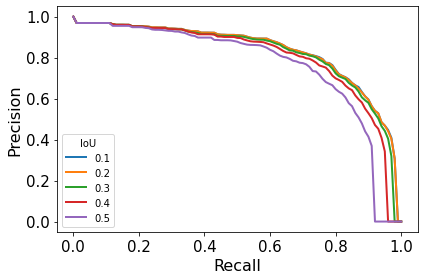

In [38]:

myeval.plot_PRcurve()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'PRCurve_'+dataset_name+'.png'),dpi=dpi)


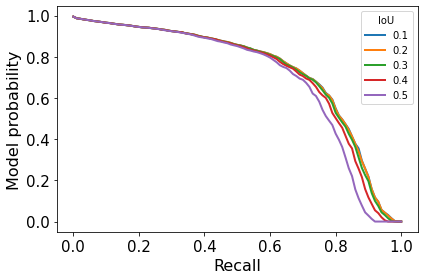

In [39]:

myeval.plot_recall_vs_prob()
plt.tight_layout()
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'ProbvsRecall_'+dataset_name+'.png'),dpi=dpi)

In [5]:

from analysis_lib import CreatePlotsRPD
RPDplt = CreatePlotsRPD.initfromcoco(myeval.mycoco,myeval.prob_thresh)

In [15]:
(RPDplt.dfvol.gt_instances==0).sum()

30

In [13]:
((RPDplt.dfvol.gt_instances>0)&(RPDplt.dfimg.dt_instances>5)).sum()

0.04491017964071856

Precision = [0.545 0.667 0.923 0.923 0.923 0.923 0.923 0.917 0.917 0.917 1.    1.
 1.    1.    1.    1.    1.    1.    1.    1.   ]
 Recall = [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 FPR = [0.357 0.214 0.036 0.036 0.036 0.036 0.036 0.034 0.034 0.034 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]



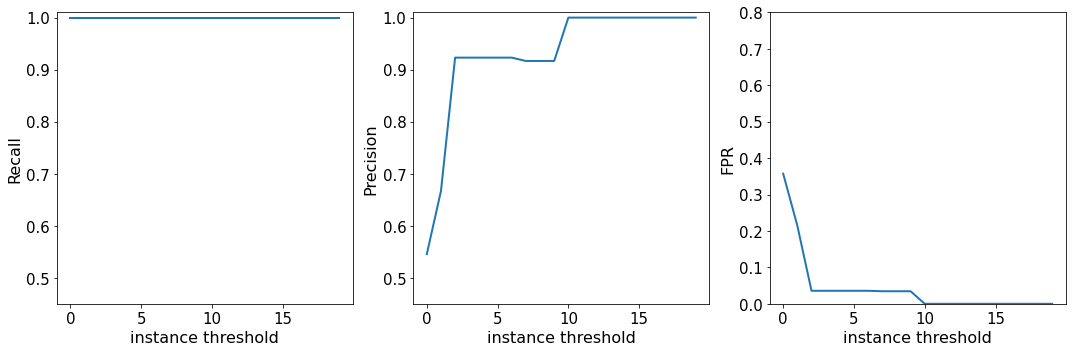

In [41]:
inst = list(range(0,20))
pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfvol,inst)
plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_eye_level_'+dataset_name+'.png'),dpi=dpi)
print('Precision = {}\n Recall = {}\n FPR = {}\n'.format(pr,rc,fpr))

In [7]:
RPDplt.dfimg.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfimg_'+dataset_name+'.csv'))
RPDplt.dfvol.to_csv(os.path.join(cfg.OUTPUT_DIR,'dfvol_'+dataset_name+'.csv'))

In [ ]:
# inst = list(range(0,6))
# #inst = [4]
# pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(RPDplt.dfimg,inst)
# plt.gcf().savefig(os.path.join(cfg.OUTPUT_DIR,'instance_thresh_scan_level_'+dataset_name+'.png'),dpi=dpi)
# print(pr,rc,fpr)

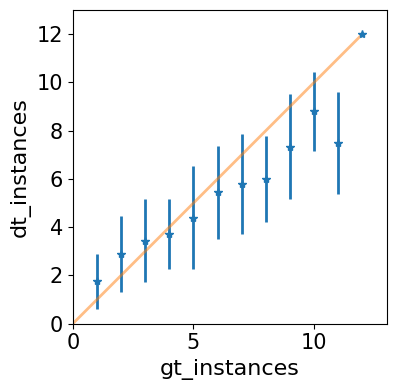

In [ ]:
fig = RPDplt.gt_vs_dt_instances()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_instances_'+dataset_name+'.png'),dpi=dpi)

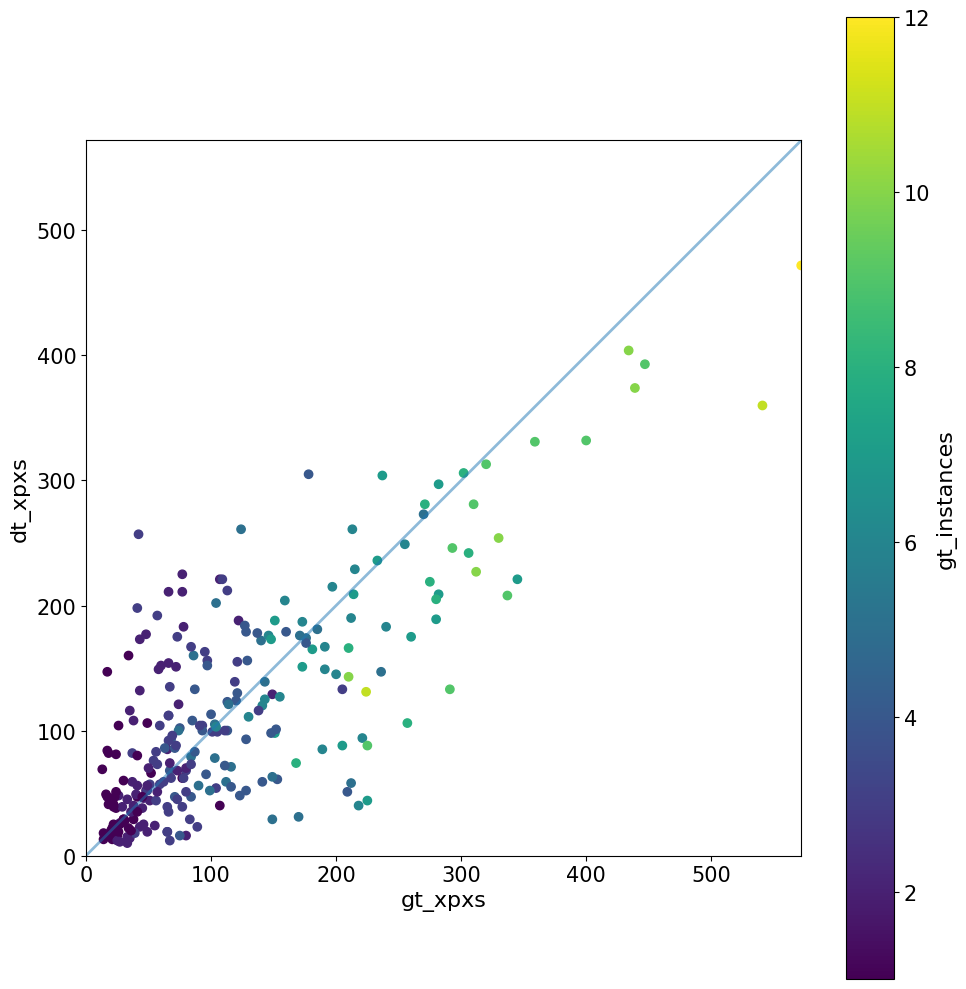

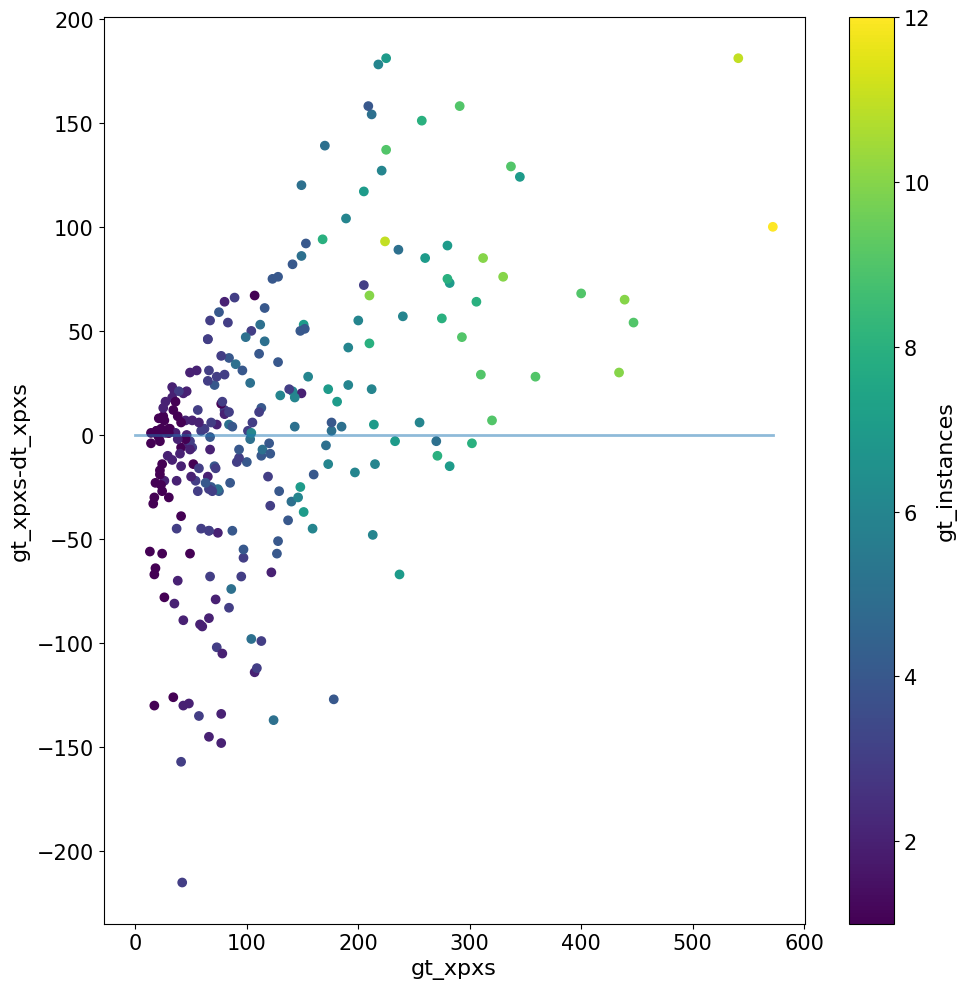

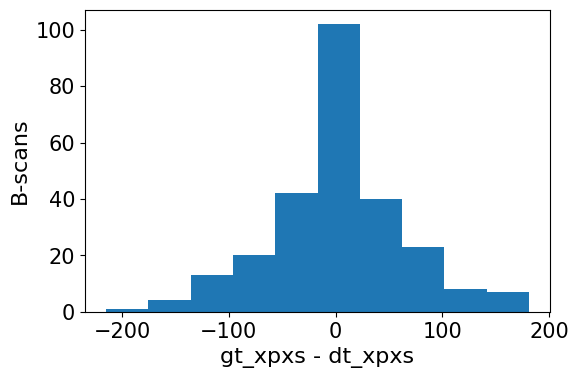

In [ ]:
fig1,fig2,fig3 = RPDplt.gt_vs_dt_xpxs()
fig1.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_xpxs_'+dataset_name+'.png'),dpi=dpi)
fig2.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_del_xpxs_'+dataset_name+'.png'),dpi=dpi)

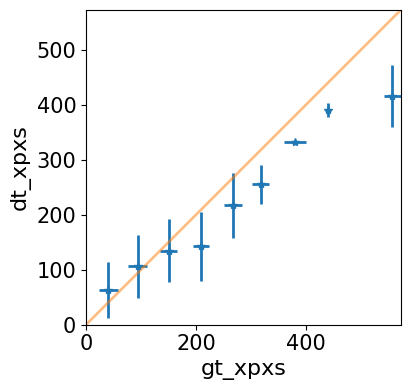

In [ ]:
fig = RPDplt.gt_vs_dt_xpxs_mu()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_mu_xpxs_'+dataset_name+'.png'),dpi=dpi)

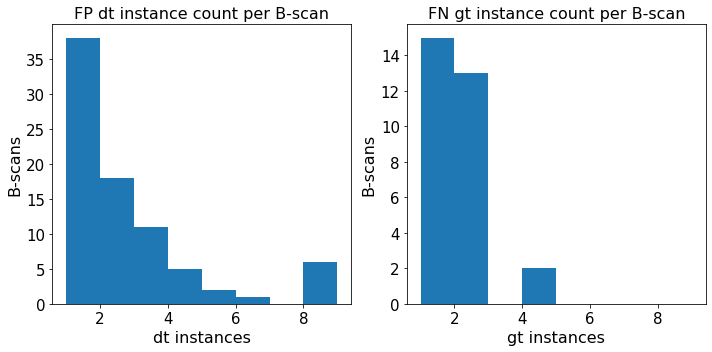

In [ ]:
fig = RPDplt.gt_dt_FP_FN_count()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'gt_dt_FP_FN_count_'+dataset_name+'.png'),dpi=dpi)

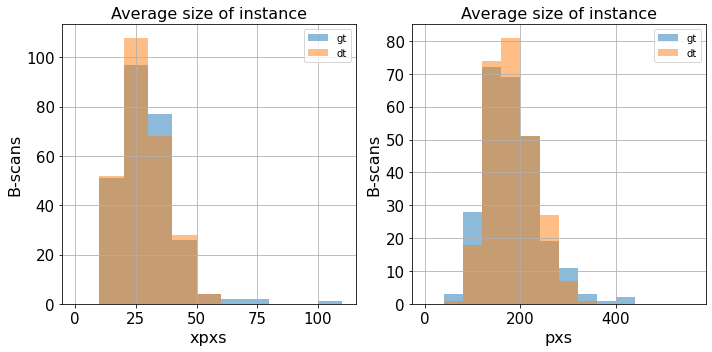

In [ ]:
fig = RPDplt.avg_inst_size()
fig.savefig(os.path.join(cfg.OUTPUT_DIR,'avg_inst_size_'+dataset_name+'.png'),dpi=dpi)

In [ ]:
df = RPDplt.dfimg
from plain_train_net import OutputVis
vis = OutputVis(dataset_name,cfg,0.5)
ImgIds = np.abs(df.gt_instances-df.dt_instances).sort_values(ascending=False).index[0:50].values
vis.output_to_pdf(ImgIds,os.path.join(cfg.OUTPUT_DIR,'top50_instances_err_'+dataset_name+'.pdf'),dfimg =df )

100%|██████████| 50/50 [00:57<00:00,  1.16s/it]


In [ ]:
dfpts = RPDplt.dfpts.sort_values(by=['gt_instances'],ascending=False)
html_str = dfpts.style.format('{:.0f}').set_table_styles(styles).render()
html_file = open(os.path.join(cfg.OUTPUT_DIR,'dfpts_'+dataset_name+'.html'),'w')
html_file.write(html_str)
html_file.close()

In [ ]:
dfpts.style.format('{:.0f}').set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

In [54]:
import json, os
import pandas as pd
from table_styles import styles
mydicts=[]
for name in ['fold1','fold2','fold3','fold4','fold5']:
    with open(os.path.join('output_valid_'+name,'results','scalar_dict_'+name+'.json')) as f:
        mydicts.append(json.load(f))
dfr = pd.DataFrame(mydicts)
dfr = dfr.assign(f1 = 2*(dfr.precision*dfr.recall)/(dfr.precision + dfr.recall))
dfr = dfr[['dataset','precision','recall','f1','fpr','iou','probability']]
pd.set_option('display.precision',2)
dfr.style.set_table_styles(styles).set_table_attributes('style="font-size: 17px"')

,dataset,precision,recall,f1,fpr,iou,probability
0,fold1,0.84,0.75,0.79,0.03,0.20,0.50
1,fold2,0.60,0.80,0.68,0.03,0.20,0.50
2,fold3,0.51,0.87,0.64,0.07,0.20,0.50
3,fold4,0.68,0.54,0.60,0.04,0.20,0.50
4,fold5,0.72,0.81,0.76,0.03,0.20,0.50


## Instance occurance at eye level ##

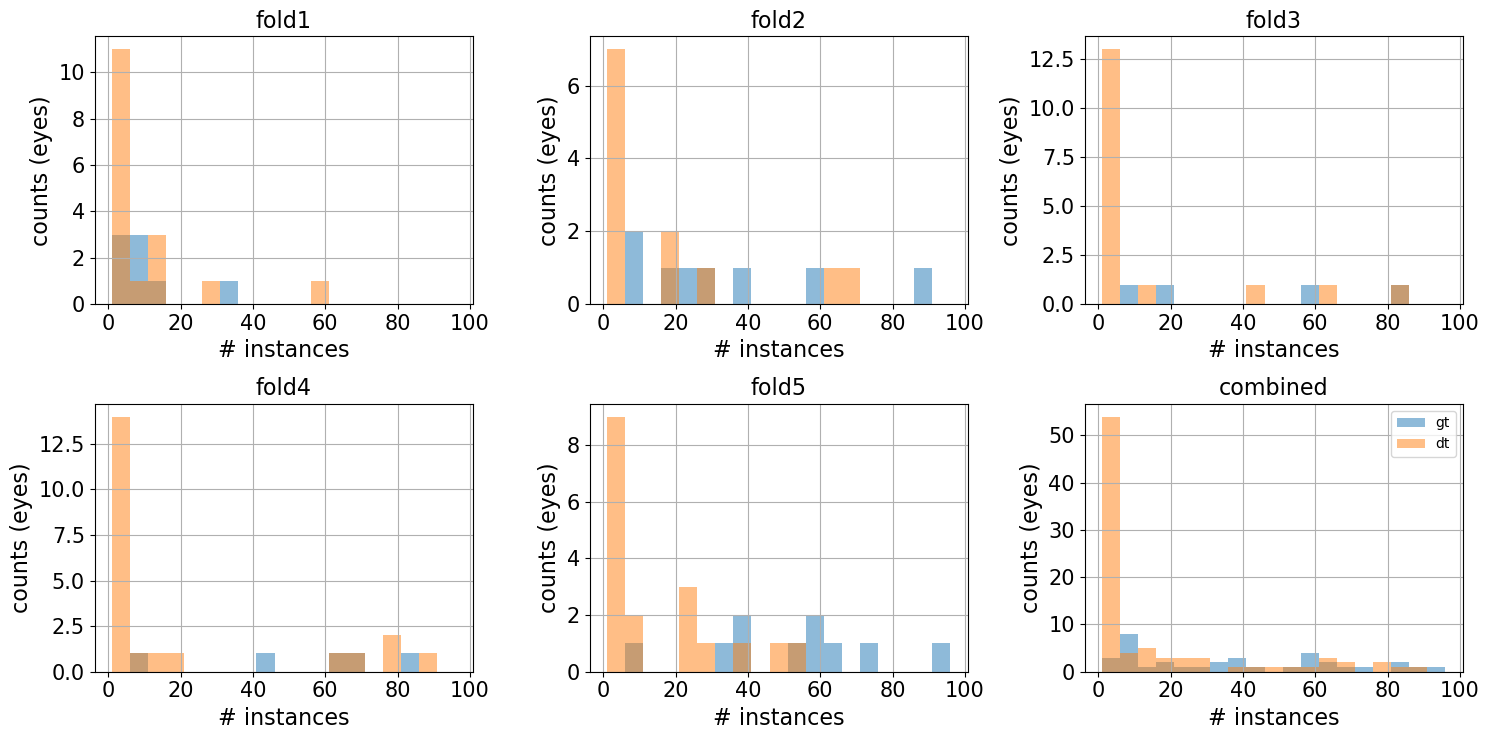

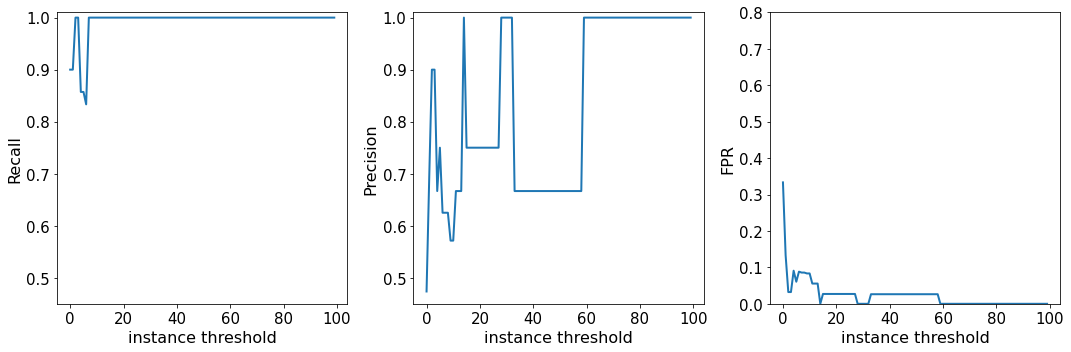

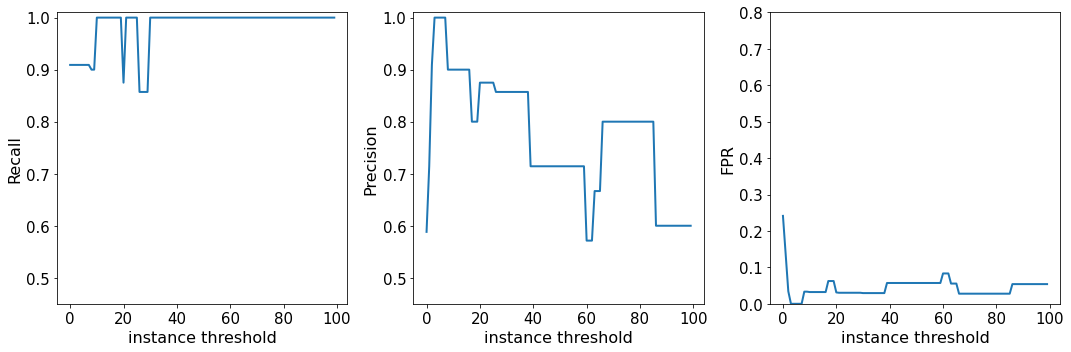

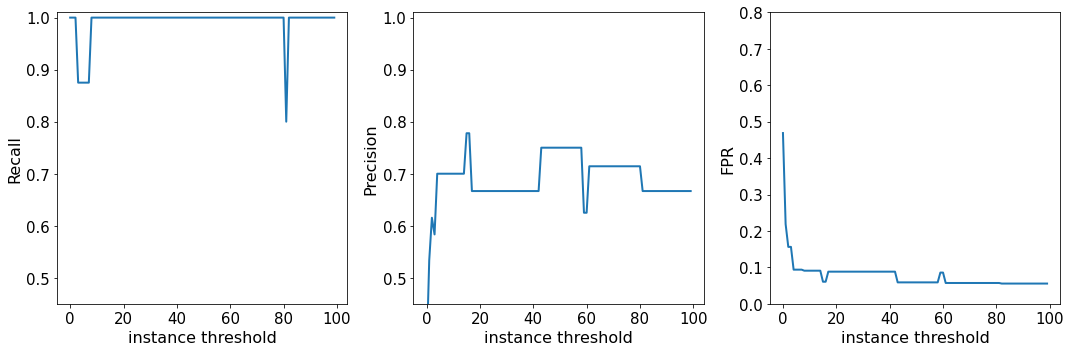

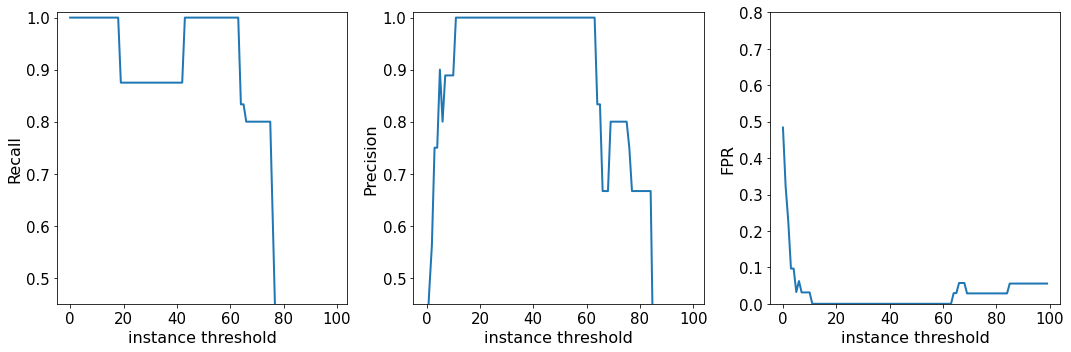

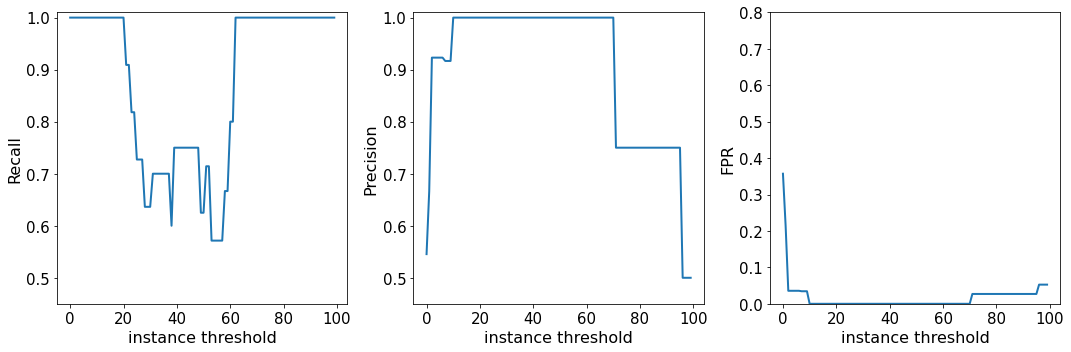

In [8]:
#%%script false --no-raise-error
#Another study looking at instance occurance at the eye level
import matplotlib.pyplot as plt
import numpy as np
import json, os
import pandas as pd
from analysis_lib import CreatePlotsRPD

df = pd.DataFrame()
dffold_scores = pd.DataFrame(columns=['validation fold','Instance threshold','RPD eyes', 'Non-RPD eyes','Precision','Recall','FPR'])
fig,ax = plt.subplots(2,3,figsize=[15,7.5],dpi=100)
ax = ax.flatten()
bins = np.arange(1,101,5)
inst_thresh = np.arange(0,100,1)

for i, name in enumerate(['fold1','fold2','fold3','fold4','fold5']):
    #dffold = pd.read_csv(os.path.join('output_valid_'+name,'results','dfpts_'+name+'.csv'))
    RPDplt = CreatePlotsRPD.initfromcsv(os.path.join('output_valid_'+name,'results','dfimg_'+name+'.csv'))
    dffold = RPDplt.dfvol
    dffold.gt_instances.hist(bins=bins, ax=ax[i], figure=fig,label='gt',alpha=0.5)
    dffold.dt_instances.hist(bins=bins, ax=ax[i], figure=fig,label='dt',alpha=0.5)
    ax[i].set_xlabel('# instances')
    ax[i].set_ylabel('counts (eyes)')
    ax[i].set_title(name)
    pr,rc,fpr = RPDplt.plot_img_level_instance_thresholding(dffold,inst_thresh)
    df = df.append(dffold.assign(fold = name))
    rpd = [(dffold.gt_instances>thresh).sum() for thresh in inst_thresh]
    nonrpd = [(dffold.gt_instances<=thresh).sum() for thresh in inst_thresh]
    dffold_scores = dffold_scores.append(pd.Series([name,inst_thresh,rpd,nonrpd,pr,rc,fpr],index=dffold_scores.columns),ignore_index=True).explode(['Instance threshold','RPD eyes','Non-RPD eyes','Precision','Recall','FPR'])
    
df.gt_instances.hist(bins = bins, ax=ax[5], figure=fig, label='gt',alpha=0.5)
df.dt_instances.hist(bins = bins, ax=ax[5], figure=fig, label='dt',alpha=0.5)
ax[5].set_xlabel('# instances')
ax[5].set_ylabel('counts (eyes)')
ax[5].set_title('combined')
ax[5].legend()
fig.tight_layout()

Text(0.5, 1.0, 'Validation Folds')

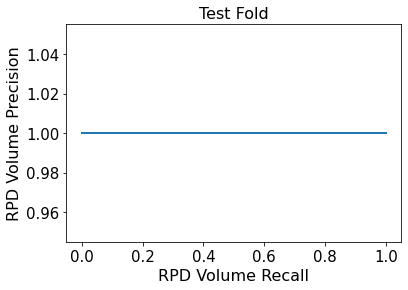

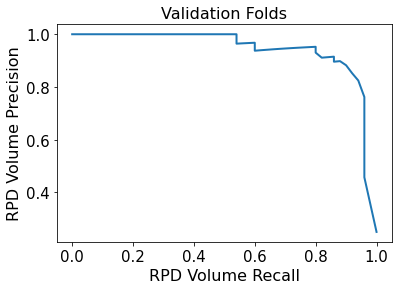

In [9]:
#validation folds precsion recall

RPDplt = CreatePlotsRPD.initfromcsv(os.path.join('output_test','dfimg_test.csv'))
dffold = RPDplt.dfvol
dffold
fig, ax = plt.subplots(1,1)
ap_test,prc_test = RPDplt.vol_level_prc(dffold,gt_thresh=1,ax=ax)
ax.set_title('Test Fold')
fig, ax = plt.subplots(1,1)
ap_folds, prc_folds = RPDplt.vol_level_prc(df,gt_thresh=1,ax=ax)
ax.set_title('Validation Folds')


{'precision': array([0.556, 0.833, 1.   ]),
 'precision_ci': array([[0.337, 0.754],
        [0.552, 0.953],
        [0.722, 1.   ]]),
 'recall': array([1., 1., 1.]),
 'recall_ci': array([[0.722, 1.   ],
        [0.722, 1.   ],
        [0.722, 1.   ]]),
 'fpr': array([0.267, 0.067, 0.   ]),
 'fpr_ci': array([[ 1.418e-01,  4.445e-01],
        [ 1.848e-02,  2.132e-01],
        [-1.230e-17,  1.135e-01]])}

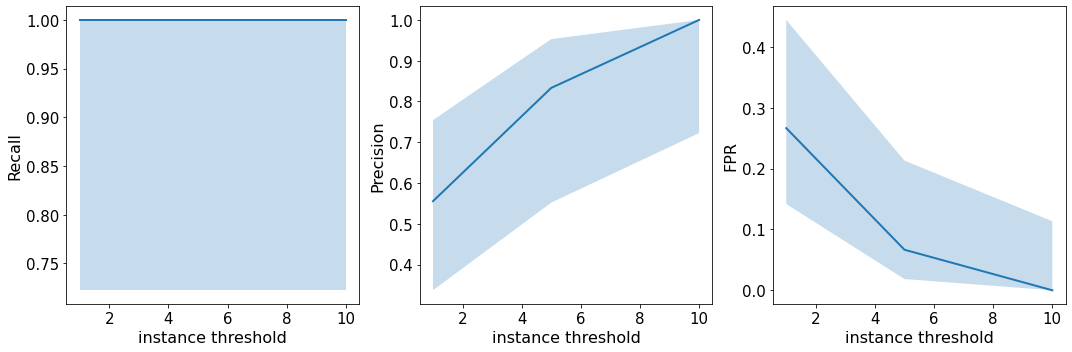

In [10]:
#inst_thresh = np.arange(0,max(df.dt_instances),1)
inst_thresh = [1,5,10]
result_dict = RPDplt.plot_img_level_instance_thresholding2(dffold,inst_thresh,gt_thresh=1)
result_dict

# Average Instances Per Scan Study

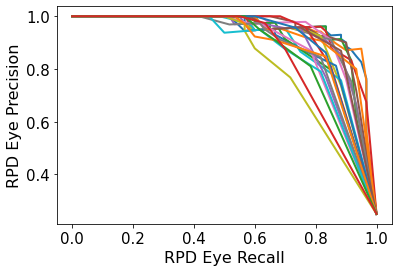

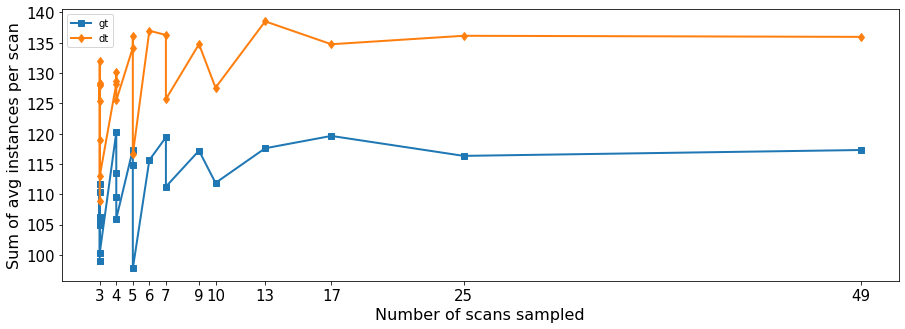

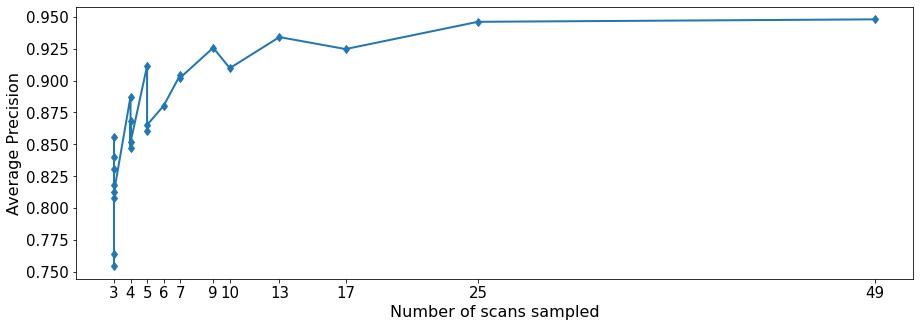

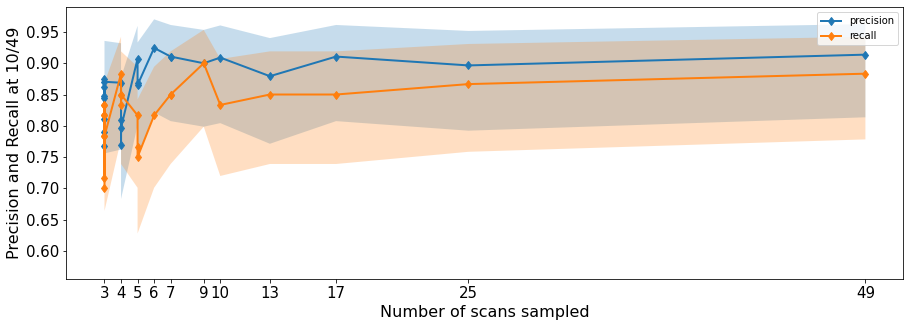

In [45]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plain_train_net import CreatePlotsRPD
df = pd.DataFrame()
for i, name in enumerate(['fold1','fold2','fold3','fold4','fold5']):
    dffold = pd.read_csv(os.path.join('output_valid_'+name,'results','dfimg_'+name+'.csv'))
    df = df.append(dffold.assign(fold = name))
dffold = pd.read_csv(os.path.join('output_test','dfimg_test.csv'))
df = df.append(dffold.assign(fold='test'))
#make gt labels
gtlabels = df.groupby(['ptid','eye']).sum()['gt_instances']>0
gtlabels = gtlabels.to_frame('RPD')

RPDplt = CreatePlotsRPD(df)
scan_str =np.array(['oct-{:03d}'.format(i) for i in range(49)])
fig,ax = plt.subplots(1,1)
avgsum = []
invlab = []
ap = []
p = []
p_ci =[]
r = []
r_ci = []
for inv in range(1,25):

    scans = scan_str[(list(range(0,49,inv)))]
    invlab.append(len(scans))
    grps = df[df.scan.isin(scans)].groupby(['ptid','eye']).mean() #avg RPD per scan for each eye
    g,d = grps[['gt_instances','dt_instances']].sum()
    avgsum.append((g,d))    
    
    grps.loc[gtlabels.index,'gt_instances'] = gtlabels['RPD']

    ap_folds, prc_folds = RPDplt.eye_level_prc(grps,gt_thresh=True,ax=ax) 
    ap.append(ap_folds)


    result_dict = RPDplt.plot_img_level_instance_thresholding2(grps,inst = [10/49],gt_thresh=True,plot=False) 
    p.append(result_dict['precision'])
    p_ci.append(result_dict['precision_ci'][0])
    r.append(result_dict['recall'])
    r_ci.append(result_dict['recall_ci'][0])

lst = list(zip(*avgsum))
p_ci = np.array(p_ci)
r_ci = np.array(r_ci)

plt.figure(figsize=[15,5])
plt.plot(invlab,lst[0],marker='s',label = 'gt')
plt.plot(invlab,lst[1],marker='d',label='dt')
plt.legend()
plt.xlabel('Number of scans sampled')
plt.ylabel('Sum of avg instances per scan')
plt.xticks(list(set(invlab)));

plt.figure(figsize=[15,5])
plt.plot(invlab,ap,marker = 'd')
plt.xlabel('Number of scans sampled')
plt.ylabel('Average Precision')
plt.xticks(list(set(invlab)));

plt.figure(figsize=[15,5])
plt.plot(invlab,p,marker = 'd',label='precision')
plt.fill_between(invlab,p_ci[:,0],p_ci[:,1],alpha=.25)
plt.plot(invlab,r,marker='d',label='recall')
plt.fill_between(invlab,r_ci[:,0],r_ci[:,1],alpha=.25)
plt.xlabel('Number of scans sampled')
plt.ylabel('Precision and Recall at 10/49')
plt.xticks(list(set(invlab)));
plt.legend()



# ARVO stuff

/root/miniconda3/envs/detectron/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6566696960517016
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!
Calculated metrics for 1960 images
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.22s).
Accumulating evaluation results...
DONE (t=0.01s).


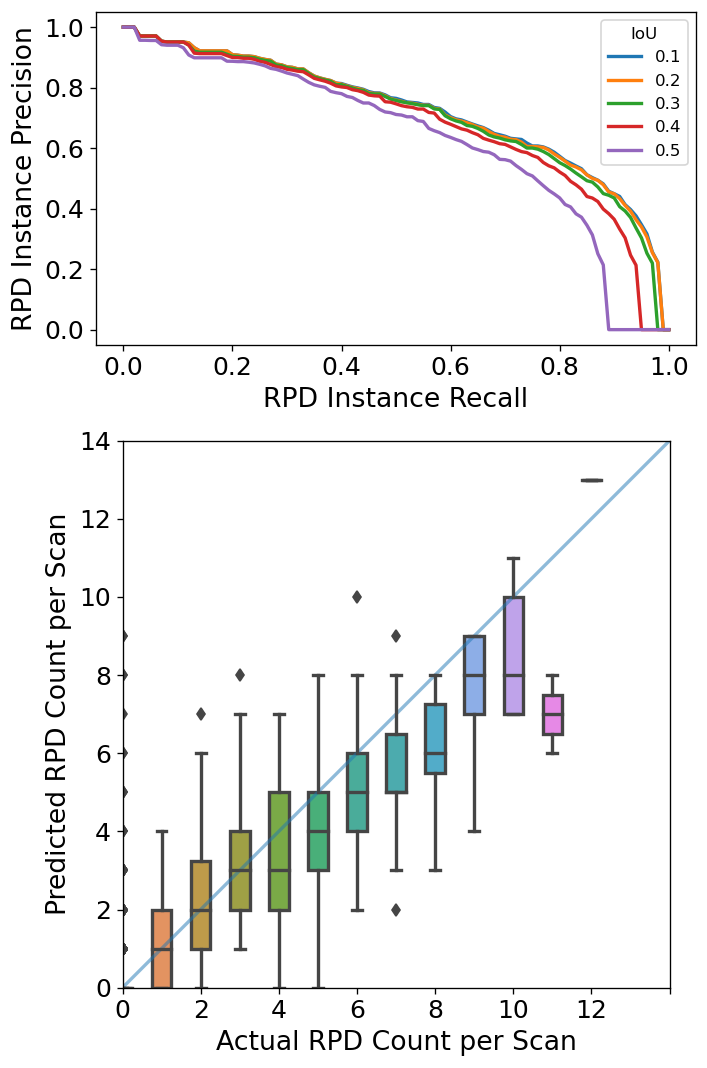

In [4]:
#ARVO 2022 Abstract figures
import matplotlib.pyplot as plt
from plain_train_net import CreatePlotsRPD,EvaluateClass


RPDplt = CreatePlotsRPD.initfromcsv(os.path.join('output_test','dfimg_test.csv'))
fig = plt.figure(figsize=[6,9],dpi=120,constrained_layout=True)
#fig,ax = plt.subplots(2,1,figsize=[6,8],dpi=100)
spec = fig.add_gridspec(5,1)
ax1 = fig.add_subplot(spec[2:,0])
RPDplt.gt_vs_dt_instances_boxplot(ax1)
ax1.set_xlabel('Actual RPD Count per Scan')
ax1.set_ylabel('Predicted RPD Count per Scan')
#fast fit
x = RPDplt.dfimg['gt_instances'].values
y = RPDplt.dfimg['dt_instances'].values
from sklearn.metrics import r2_score
print(r2_score(x,y))


ax0 = fig.add_subplot(spec[:2,0])
myeval = EvaluateClass(
    'test', 'output_test',iou_thresh = .2,prob_thresh=0.5,evalsuper=False)
myeval.evaluate()
myeval.plot_PRcurve(ax0)
ax0.set_xlabel('RPD Instance Recall')
ax0.set_ylabel('RPD Instance Precision')

plt.tight_layout()

fig.savefig('ARVO 2022/PRC_gtvsdtinstance.jpeg',dpi=300)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


0.6566696960517016


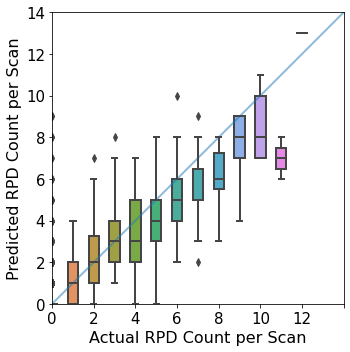

In [12]:
#ARVO 2022 Abstract figures
import matplotlib.pyplot as plt
from analysis_lib import CreatePlotsRPD,EvaluateClass


RPDplt = CreatePlotsRPD.initfromcsv(os.path.join('output_test','dfimg_test.csv'))
#fig = plt.figure(figsize=[6,9],dpi=120,constrained_layout=True)
#fig,ax = plt.subplots(2,1,figsize=[6,8],dpi=100)
fig,ax = plt.subplots(1,1,figsize=[5,5],constrained_layout=True)
RPDplt.gt_vs_dt_instances_boxplot(ax)
ax.set_xlabel('Actual RPD Count per Scan')
ax.set_ylabel('Predicted RPD Count per Scan')
#fast fit
x = RPDplt.dfimg['gt_instances'].values
y = RPDplt.dfimg['dt_instances'].values
from sklearn.metrics import r2_score
print(r2_score(x,y))


plt.tight_layout()

fig.savefig('ARVO 2022/gtvsdtinstance.svg')

## External test labels

In [1]:
import pandas as pd
df_pred = pd.read_csv('output_ext_test/dfimg_ext_test.csv')
from analysis_lib import CreatePlotsRPD
RPDplt = CreatePlotsRPD(df_pred)

In [2]:
df_gt = pd.read_csv('datasets/CERA_external_test_labels.csv',sep='\t',names=['ptid','eye','gt_instances'])
df_gt.loc[:,'volID'] = df_gt['ptid'].astype(str)+'_'+df_gt['eye'].astype(str)
df_gt = df_gt[['volID','gt_instances']].set_index('volID')
df_gt

,gt_instances
volID,
101002_OD,0
101002_OS,0
101007_OD,1
101007_OS,0
101021_OD,1
...,...
101072_OS,0
102040_OD,0
102040_OS,0


In [3]:
dff = df_gt.merge(RPDplt.dfvol.drop('gt_instances',axis=1),right_index=True,left_index=True)
print('Num neg. vols = ', (dff.gt_instances==0).sum())
print('Num pos. vols = ', (dff.gt_instances>0).sum())

Num neg. vols =  212
Num pos. vols =  70


0.9760821809278875


{'precision': array([0.51851852, 0.82926829, 0.95652174]),
 'precision_ci': array([[0.4348917 , 0.60112056],
        [0.73358062, 0.895485  ],
        [0.87978603, 0.98510437]]),
 'recall': array([1.        , 0.97142857, 0.94285714]),
 'recall_ci': array([[0.94797513, 1.        ],
        [0.90167556, 0.99212955],
        [0.86207853, 0.97755658]]),
 'fpr': array([0.30660377, 0.06603774, 0.01415094]),
 'fpr_ci': array([[0.2484365 , 0.37165527],
        [0.03974101, 0.10778199],
        [0.00482397, 0.04077243]])}

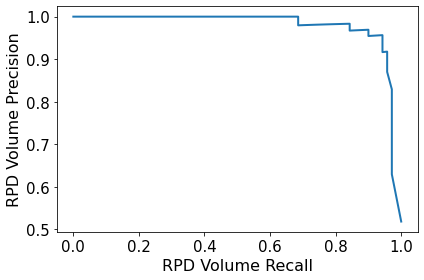

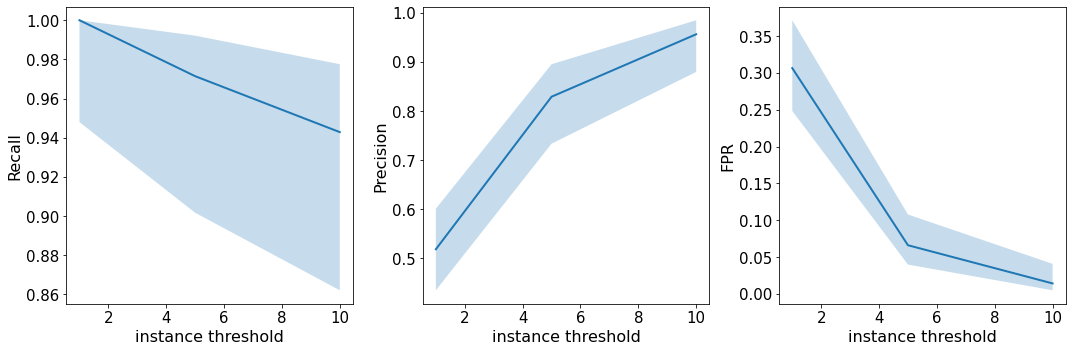

In [4]:
import matplotlib.pyplot as plt
fig,ax  = plt.subplots(1,1)
ap,prc = RPDplt.vol_level_prc(dff,gt_thresh=1,ax=ax)
print(ap)
plt.tight_layout()
fig.savefig('ARVO 2022/vol-level-prc.svg',dpi=300)

# import numpy as np
# idx = np.argwhere(prc[2]==5)
# p = prc[0][idx]
# r = prc[1][idx]
# ax.plot(p,r,'.',markersize=10)

RPDplt.plot_img_level_instance_thresholding2(dff,[1,5,10],1)

In [26]:
from table_styles import styles
html_str = table.style.set_table_styles(styles).render()
html_file = open('ARVO 2022/eye_level_val.html','w')
html_file.write(html_str)
html_file.close()
import imgkit
imgkit.from_file('ARVO 2022/eye_level_val.html','ARVO 2022/eye_level_val.jpeg',options={"xvfb": ""})

In [6]:
#check splits
dfsplits = df[['ptid','fold']].set_index('fold')
splitdict={}
for split in dfsplits.index.drop_duplicates():
    splitdict[split] = set(dfsplits.loc[split,'ptid'])
splitdict
dfcheck = pd.DataFrame(index = splitdict.keys(),columns=splitdict.keys())
for key,value in splitdict.items():
    for key2,value2 in splitdict.items():
        dfcheck.loc[key,key2]= (len(set.intersection(value,value2)))
dfcheck

,fold1,fold2,fold3,fold4,fold5,test
fold1,20,0,0,0,0,0
fold2,0,20,0,0,0,0
fold3,0,0,20,0,0,0
fold4,0,0,0,20,0,0
fold5,0,0,0,0,20,0
test,0,0,0,0,0,20
